# Prediction on Streams of Spotify’s Most Listened Songs

**Goal**: To build a random forests model and a neural networts model respectively to predict 'Streams' of Spotify's most listened songs.

In [151]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

In [152]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn import metrics

from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

+ df_data is Spotify's Worldwide Daily Song Ranking. This dataset is used for understanding streams and positions of tracks.
+ df2 is Top Spotify Tracks of 2018
+ df3 is Top Spotify Tracks of 2017 
+ The audio features for each song were extracted using the Spotify Web API and the Spotify Python library
+ The two datasets above are for pairing track names with their qualitative features

In [203]:
df_data = pd.read_csv('data.csv')
df2 = pd.read_csv('top2018.csv')
df3 = pd.read_csv('featuresdf.csv')

df_data.columns = (df_data.columns.str.lower()
                .str.replace(' ', '_'))
print(df_data.shape)

df_data.head()

(3441197, 7)


,position,track_name,artist,streams,url,date,region
0,1,Reggaetón Lento (Bailemos),CNCO,19272,https://open.spotify.com/track/3AEZUABDXNtecAO...,2017-01-01,ec
1,2,Chantaje,Shakira,19270,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,2017-01-01,ec
2,3,Otra Vez (feat. J Balvin),Zion & Lennox,15761,https://open.spotify.com/track/3QwBODjSEzelZyV...,2017-01-01,ec
3,4,Vente Pa' Ca,Ricky Martin,14954,https://open.spotify.com/track/7DM4BPaS7uofFul...,2017-01-01,ec
4,5,Safari,J Balvin,14269,https://open.spotify.com/track/6rQSrBHf7HlZjtc...,2017-01-01,ec


In [204]:
df2.columns

Index(['id', 'name', 'artists', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')

In [205]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3441197 entries, 0 to 3441196
Data columns (total 7 columns):
position      int64
track_name    object
artist        object
streams       int64
url           object
date          object
region        object
dtypes: int64(2), object(5)
memory usage: 183.8+ MB


## Data Preprocessing
+ a. Drop all missing value and drop ‘url’ column.
+ b. Combine ranking data with audio features. This will drop all track names that are not stored in the features data. We can use this to draw out the list of track names that have reached the top 100 list of 2017.
+ c. Split data column (e.g. 2017-01-01) into year, month and day.
+ d. Convert data of object dtype to numerical values (track name, artist, region…)
+ e. Use StandardScalar() to transform all numerical input data.
+ f. Split Data into Train-Valid-Test sets (train_valid : test = 0.88:0.12, train :
valid=0.85:0.15)

In [206]:
# Check how many NaNs there are
df_data.isnull().sum()

position        0
track_name    657
artist        657
streams         0
url             8
date            0
region          0
dtype: int64

In [207]:
df_data.dropna(inplace=True)

#Dropping Url as they are also not needed.
df_data.drop('url', axis=1, inplace=True)

df_data.isnull().sum()

position      0
track_name    0
artist        0
streams       0
date          0
region        0
dtype: int64

Text(0.5, 1.0, 'Streams vs Time')

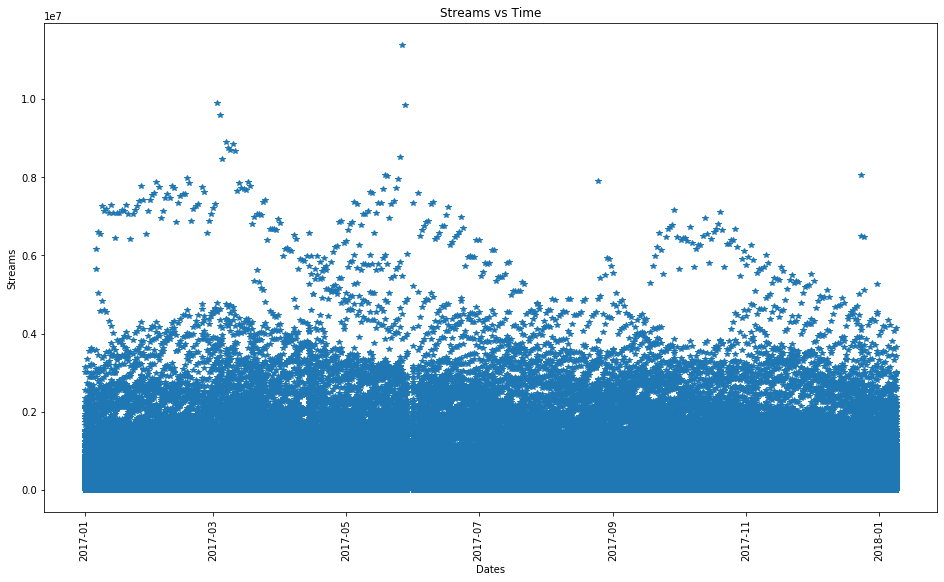

In [208]:
df_data['date'] = df_data['date'].astype('datetime64[ns]')
plt.rcParams["figure.figsize"] = [16,9]
plt.plot(df_data['date'], df_data['streams'],'*')
plt.xticks(rotation='vertical')
plt.ylabel('Streams')
plt.xlabel('Dates')
plt.title('Streams vs Time')

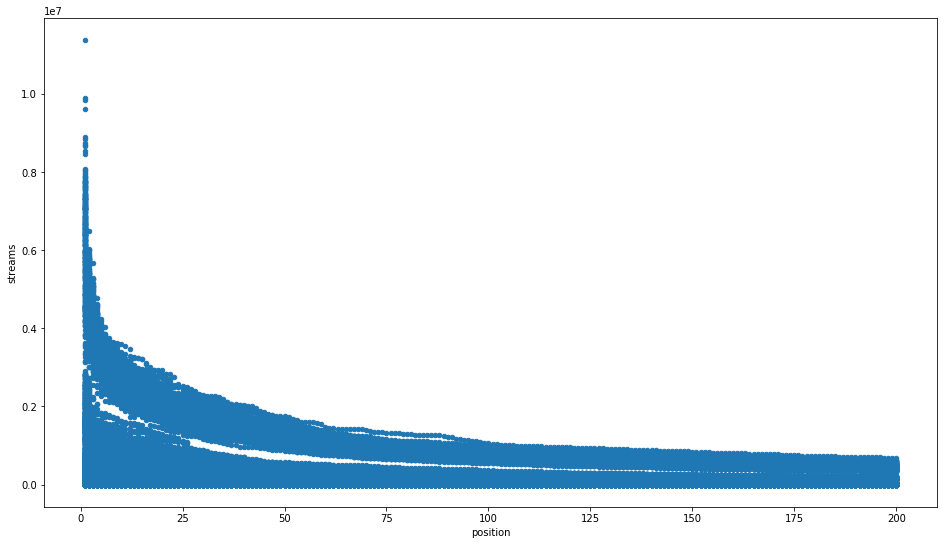

In [209]:
ax1 = df_data.plot.scatter(x='position', y='streams')

In [210]:
df_data.corr()

,position,streams
position,1.000000,-0.133948
streams,-0.133948,1.000000


In [212]:
print(df_data.columns,'\n')
print(df2.columns)

Index(['position', 'track_name', 'artist', 'streams', 'date', 'region'], dtype='object') 

Index(['id', 'name', 'artists', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')


In [211]:
df3 = df3.rename(columns={'name': 'track_name'})
df3 = df3.drop(columns=['id'])
df3.head()

,track_name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Shape of You,Ed Sheeran,0.825,0.652,1.0,-3.183,0.0,0.0802,0.5810,0.000000,0.0931,0.931,95.977,233713.0,4.0
1,Despacito - Remix,Luis Fonsi,0.694,0.815,2.0,-4.328,1.0,0.1200,0.2290,0.000000,0.0924,0.813,88.931,228827.0,4.0
2,Despacito (Featuring Daddy Yankee),Luis Fonsi,0.660,0.786,2.0,-4.757,1.0,0.1700,0.2090,0.000000,0.1120,0.846,177.833,228200.0,4.0
3,Something Just Like This,The Chainsmokers,0.617,0.635,11.0,-6.769,0.0,0.0317,0.0498,0.000014,0.1640,0.446,103.019,247160.0,4.0
4,I'm the One,DJ Khaled,0.609,0.668,7.0,-4.284,1.0,0.0367,0.0552,0.000000,0.1670,0.811,80.924,288600.0,4.0


In [213]:
df2 = df2.rename(columns={'name': 'track_name'})
df2 = df2.drop(columns=['id'])
df3.head()

,track_name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Shape of You,Ed Sheeran,0.825,0.652,1.0,-3.183,0.0,0.0802,0.5810,0.000000,0.0931,0.931,95.977,233713.0,4.0
1,Despacito - Remix,Luis Fonsi,0.694,0.815,2.0,-4.328,1.0,0.1200,0.2290,0.000000,0.0924,0.813,88.931,228827.0,4.0
2,Despacito (Featuring Daddy Yankee),Luis Fonsi,0.660,0.786,2.0,-4.757,1.0,0.1700,0.2090,0.000000,0.1120,0.846,177.833,228200.0,4.0
3,Something Just Like This,The Chainsmokers,0.617,0.635,11.0,-6.769,0.0,0.0317,0.0498,0.000014,0.1640,0.446,103.019,247160.0,4.0
4,I'm the One,DJ Khaled,0.609,0.668,7.0,-4.284,1.0,0.0367,0.0552,0.000000,0.1670,0.811,80.924,288600.0,4.0


In [214]:
# consider only in us
df_data = df_data[df_data['region'].str.contains("us")]

In [215]:
df_data.describe(include='all')

,position,track_name,artist,streams,date,region
count,74184.000000,74184,74184,7.418400e+04,74184,74184
unique,NaN,1624,487,NaN,371,1
top,NaN,Unforgettable,Drake,NaN,2017-06-08 00:00:00,us
freq,NaN,431,3210,NaN,200,74184
first,NaN,NaN,NaN,NaN,2017-01-01 00:00:00,NaN
last,NaN,NaN,NaN,NaN,2018-01-09 00:00:00,NaN
mean,100.501146,NaN,NaN,3.555777e+05,NaN,NaN
std,57.732890,NaN,NaN,2.586445e+05,NaN,NaN
min,1.000000,NaN,NaN,1.224880e+05,NaN,NaN
25%,51.000000,NaN,NaN,2.015878e+05,NaN,NaN


In [216]:
df_data.artist.describe()

count     74184
unique      487
top       Drake
freq       3210
Name: artist, dtype: object

In [217]:
df_data.position.describe()

count    74184.000000
mean       100.501146
std         57.732890
min          1.000000
25%         51.000000
50%        100.500000
75%        150.000000
max        200.000000
Name: position, dtype: float64

In [218]:
df_data.track_name.describe()

count             74184
unique             1624
top       Unforgettable
freq                431
Name: track_name, dtype: object

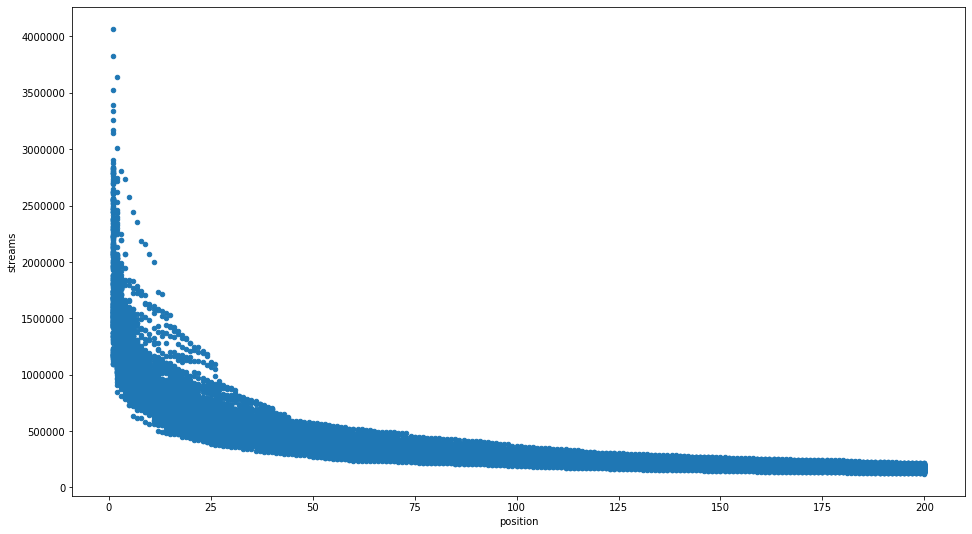

In [167]:
ax1 = df.plot.scatter(x='position', y='streams')

In [219]:
df_data['date'].min() #First date entry

Timestamp('2017-01-01 00:00:00')

In [220]:
df_data['date'].max() #Last date entry

Timestamp('2018-01-09 00:00:00')

In [221]:
df = df_data
dftest = df[(df['date'] > '2017-12-31')]
df=df[(df['date'] < '2018-01-01')]

In [222]:
dftest.head()

,position,track_name,artist,streams,date,region
844022,1,rockstar,Post Malone,1502394,2018-01-01,us
844023,2,No Limit,G-Eazy,1027039,2018-01-01,us
844024,3,Gucci Gang,Lil Pump,930620,2018-01-01,us
844025,4,Bartier Cardi (feat. 21 Savage),Cardi B,877478,2018-01-01,us
844026,5,Havana,Camila Cabello,860232,2018-01-01,us


In [172]:
dftest.tail()

,position,track_name,artist,streams,date,region
845817,196,Portland,Drake,184537,2018-01-09,us
845818,197,All On Me,Devin Dawson,184519,2018-01-09,us
845819,198,From The D To The A (feat. Lil Yachty),Tee Grizzley,184428,2018-01-09,us
845820,199,Now Or Never,Halsey,184394,2018-01-09,us
845821,200,So Good (& Metro Boomin),Big Sean,184149,2018-01-09,us


Combine ranking data with song features  
This will give us insight on position and streams related to song qualities.  This will drop all track names that are not stored in the features data. We can use this to draw out the list of track names that have reached the top 100 list of 2017.

In [173]:
print(df.shape)
print(dftest.shape)

(72384, 6)
(1800, 6)


In [174]:
dfnew = pd.merge(df, df3, on='track_name')
dfnew = dfnew.drop(columns=['artists'])
dfnew.sort_values(by='date')
dfnew.head()

,position,track_name,artist,streams,date,region,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,1,Bad and Boujee (feat. Lil Uzi Vert),Migos,1371493,2017-01-01,us,0.927,0.665,11.0,-5.313,1.0,0.244,0.061,0.0,0.123,0.175,127.076,343150.0,4.0
1,1,Bad and Boujee (feat. Lil Uzi Vert),Migos,1161746,2017-01-02,us,0.927,0.665,11.0,-5.313,1.0,0.244,0.061,0.0,0.123,0.175,127.076,343150.0,4.0
2,1,Bad and Boujee (feat. Lil Uzi Vert),Migos,1284891,2017-01-03,us,0.927,0.665,11.0,-5.313,1.0,0.244,0.061,0.0,0.123,0.175,127.076,343150.0,4.0
3,1,Bad and Boujee (feat. Lil Uzi Vert),Migos,1293486,2017-01-04,us,0.927,0.665,11.0,-5.313,1.0,0.244,0.061,0.0,0.123,0.175,127.076,343150.0,4.0
4,1,Bad and Boujee (feat. Lil Uzi Vert),Migos,1295592,2017-01-05,us,0.927,0.665,11.0,-5.313,1.0,0.244,0.061,0.0,0.123,0.175,127.076,343150.0,4.0


In [175]:
print(dfnew.shape)

(20406, 19)


In [176]:
"""Seperate out X and y"""

y_dfnew = dfnew['streams']
X_dfnew = dfnew.drop(['streams'], axis=1)

print(X_dfnew.shape, y_dfnew.shape)

(20406, 18) (20406,)


In [177]:
"""Split data into train-valid set and test set"""

(X_train_valid, X_test, y_train_valid, y_test) = train_test_split(X_dfnew, 
                                                                  y_dfnew, 
                                                                  test_size=0.12)

print('Shape:')
print('Train-Valid Set -', X_train_valid.shape, y_train_valid.shape)
print('Test Set -', X_test.shape, y_test.shape)

Shape:
Train-Valid Set - (17957, 18) (17957,)
Test Set - (2449, 18) (2449,)


In [178]:
X_train_valid['date'] =  pd.to_datetime(X_train_valid['date'], format='%Y-%m-%d')

/Users/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [179]:
X_test['date'] =  pd.to_datetime(X_test['date'], format='%Y-%m-%d')

/Users/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [180]:
import datetime

def split_date(df, date):
    """Function to split df[date_column] into four other date relevant columns
       df: a DataFrame object
       data_column: name of the column with datetime64 dtype - str
    """
    df = df.copy()
    date_df = pd.DataFrame({"year": df[date].dt.year,
                            "month": df[date].dt.month,
                            "day": df[date].dt.day
             })
    df = df.drop(date, axis=1)
    df = pd.concat([df, date_df], axis=1)
    return df

"""Split 'Data' column"""

X_train_valid_2 = split_date(X_train_valid, 'date')

X_test_2 = split_date(X_test, 'date')

X_train_valid_2.tail()

,position,track_name,artist,region,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,month,day
18471,3,Wild Thoughts,DJ Khaled,us,0.671,0.672,0.0,-3.094,0.0,0.0688,0.03290,0.00000,0.1180,0.632,97.980,204173.0,4.0,2017,6,24
6862,15,Congratulations,Post Malone,us,0.627,0.812,6.0,-4.215,1.0,0.0358,0.19800,0.00000,0.2120,0.504,123.071,220293.0,4.0,2017,4,21
1615,84,One Dance,Drake,us,0.791,0.619,1.0,-5.886,1.0,0.0532,0.00784,0.00423,0.3510,0.371,103.989,173987.0,4.0,2017,7,3
80,35,Bad and Boujee (feat. Lil Uzi Vert),Migos,us,0.927,0.665,11.0,-5.313,1.0,0.2440,0.06100,0.00000,0.1230,0.175,127.076,343150.0,4.0,2017,3,22
15631,33,There's Nothing Holdin' Me Back,Shawn Mendes,us,0.857,0.800,2.0,-4.035,1.0,0.0583,0.38100,0.00000,0.0913,0.966,121.996,199440.0,4.0,2017,5,16


In [181]:
X_train_valid_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17957 entries, 6966 to 15631
Data columns (total 20 columns):
position            17957 non-null int64
track_name          17957 non-null object
artist              17957 non-null object
region              17957 non-null object
danceability        17957 non-null float64
energy              17957 non-null float64
key                 17957 non-null float64
loudness            17957 non-null float64
mode                17957 non-null float64
speechiness         17957 non-null float64
acousticness        17957 non-null float64
instrumentalness    17957 non-null float64
liveness            17957 non-null float64
valence             17957 non-null float64
tempo               17957 non-null float64
duration_ms         17957 non-null float64
time_signature      17957 non-null float64
year                17957 non-null int64
month               17957 non-null int64
day                 17957 non-null int64
dtypes: float64(13), int64(4), object(3

In [182]:
def convert_cat_to_num(df, feature, mapping=None):
    """
       convert object dtype data in df[feature] to numerical values
       df: a DateFrame object
       feature: a feature of the df - str
       mapping: categories and their mapping values - None/dict 
    """
    df = df.copy()
    cats_list = df[feature].astype('category').cat.categories.tolist()
    if mapping is None:
        mapping = {k: v for k, v in zip(cats_list, list(range(1, len(cats_list) + 1)))}
        
    else:
        new_cats_list = []
        for c in cats_list:
            if c not in mapping:
                new_cats_list.append(c)
        start = len(mapping) + 1
        mapping.update({k: v for k, v in zip(new_cats_list, list(range(start, len(new_cats_list) + start)))})
                                    
    df[feature] = df[feature].map(mapping)
    return df, mapping   

In [183]:
"""
Convert data of object dtype to numerical values
"""
X_train_valid_3, track_name_map = convert_cat_to_num(X_train_valid_2, 'track_name')
X_train_valid_3, artist_map = convert_cat_to_num(X_train_valid_3, 'artist')
X_train_valid_3, region_map = convert_cat_to_num(X_train_valid_3, 'region')
print(X_train_valid_3.info())

X_test_3, track_name_map = convert_cat_to_num(X_test_2, 'track_name')
X_test_3, artist_map = convert_cat_to_num(X_test_3, 'artist')
X_test_3, region_map = convert_cat_to_num(X_test_3, 'region')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17957 entries, 6966 to 15631
Data columns (total 20 columns):
position            17957 non-null int64
track_name          17957 non-null int64
artist              17957 non-null int64
region              17957 non-null int64
danceability        17957 non-null float64
energy              17957 non-null float64
key                 17957 non-null float64
loudness            17957 non-null float64
mode                17957 non-null float64
speechiness         17957 non-null float64
acousticness        17957 non-null float64
instrumentalness    17957 non-null float64
liveness            17957 non-null float64
valence             17957 non-null float64
tempo               17957 non-null float64
duration_ms         17957 non-null float64
time_signature      17957 non-null float64
year                17957 non-null int64
month               17957 non-null int64
day                 17957 non-null int64
dtypes: float64(13), int64(7)
memory usage

In [184]:
X_train_valid_3.isnull().sum()

position            0
track_name          0
artist              0
region              0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
year                0
month               0
day                 0
dtype: int64

In [185]:
X_train_valid_3 = X_train_valid_3.drop(['position'], axis=1)
X_train_valid_3.columns

X_test_3 = X_test_3.drop(['position'], axis=1)


In [186]:
"""Standardize continuous variables"""

X_train_valid_4 = X_train_valid_3
# scaler = MinMaxScaler()
scaler = StandardScaler()

con_cols = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']

X_train_valid_4[con_cols] = scaler.fit_transform(X_train_valid_4[con_cols])

print(X_train_valid_4.head())

X_test_4 = X_test_3
X_test_4[con_cols] = scaler.fit_transform(X_test_4[con_cols])

       track_name  artist  region  danceability    energy       key  loudness  \
6966           19      61       1     -0.644312  1.242608  0.225590  0.852199   
2085           12       7       1      0.511506 -0.534509 -0.837783  0.085116   
2958           37      76       1      0.228614 -1.375920 -1.369469 -1.299049   
18112          26      75       1      0.325606  1.619792  0.757276  1.387037   
12897          59      21       1      0.826730 -1.288877  1.554805 -2.852355   

           mode  speechiness  acousticness  instrumentalness  liveness  \
6966   0.767630    -0.743540      0.141558         -0.200517  0.905093   
2085   0.767630     0.547276     -0.395047         -0.200517 -0.313195   
2958   0.767630    -0.533040     -0.636808         -0.200038  2.487467   
18112 -1.302711    -0.520058     -0.859527         -0.198872 -0.869126   
12897  0.767630    -0.708302      0.476215          2.934556 -0.537248   

        valence     tempo  duration_ms  time_signature  year  month 

In [187]:
"""split train-valid set into training set and validation set"""

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid_4, 
                                                      y_train_valid, 
                                                      train_size=0.85, 
                                                      shuffle=False)

print('Shape:')
print('Train Set -', X_train.shape, y_train.shape)
print('Validation Set -', X_valid.shape, y_valid.shape)

Shape:
Train Set - (15263, 19) (15263,)
Validation Set - (2694, 19) (2694,)


## Modeling
Build a random forests model with the best max_features/n_estimato  
Best max_features/n_estimators: auto/100  

In [188]:
"""tune parameters with multiple for-loops"""

max_features = ["auto", "sqrt", "log2", None]
n_estimators = [50, 100, 250]
combination_rf = []
r2_result_rf = []
for m in max_features:
    for n in n_estimators:
        combination_rf.append(str(m)+"/"+str(n))
        rfr = RandomForestRegressor(n_jobs=-1, max_features=m, n_estimators=n)
        rfr.fit(X_train, y_train)
        r2_result_rf.append(rfr.score(X_valid, y_valid))
        
r2_result_rf_df = pd.DataFrame({"combination": combination_rf, "vld_r2_rf": r2_result_rf})

r2_result_rf_df

,combination,vld_r2_rf
0,auto/50,0.977384
1,auto/100,0.978085
2,auto/250,0.977873
3,sqrt/50,0.969466
4,sqrt/100,0.970410
5,sqrt/250,0.971087
6,log2/50,0.970401
7,log2/100,0.968305
8,log2/250,0.970211
9,None/50,0.977653


In [189]:
# find the best max_features/n_estimators combination

rsq_max = max(r2_result_rf)
index = r2_result_rf.index(rsq_max)

print('vld_rsq maximum:', rsq_max, 'index:', index)
print('Best max_features/n_estimators:', combination_rf[index])

vld_rsq maximum: 0.978084972258671 index: 1
Best max_features/n_estimators: auto/100


In [190]:
"""build a random forests model with the best max_features/n_estimators combination"""

rf_model = RandomForestRegressor(n_jobs=-1, max_features='auto', n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

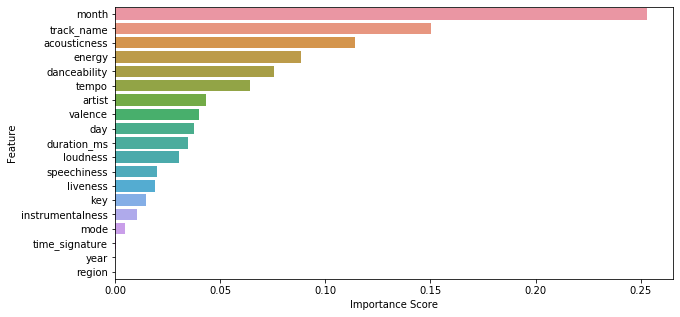

In [191]:
'''plot importance scores of data features'''

plt.figure(figsize=(10, 5))
rf_model.feature_importances_
feat_imps = pd.DataFrame(rf_model.feature_importances_, index = X_train.columns,
            columns=['Importance score']).sort_values('Importance score', ascending=False)

feat_imps = feat_imps.reset_index()
feat_imps.columns = ["Feature", "Importance Score"]
sns.barplot(x="Importance Score", y="Feature", data=feat_imps, orient="h")

The top 5 features which influence streams are :  
+ Month
+ Track name
+ Acousticness (There is a high preference for little to no acousticness)
+ Energy (higher)
+ Danceability (higher)

In [192]:
"""drop those columns with little importance"""

X_train_final = X_train.drop(['year', 'time_signature','region'], axis=1)
X_valid_final = X_valid.drop(['year', 'time_signature','region'], axis=1)

print(X_train_final.shape, X_valid_final.shape)

X_test_final = X_test_4.drop(['year', 'time_signature','region'], axis=1)

(15263, 16) (2694, 16)


In [193]:
# create random forest model

rf_model.fit(X_train_final, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [228]:
X_y_train = X_train_final
X_y_train['stream'] = y_train
corr = X_y_train.corr()
corr.style.background_gradient(cmap='cool').set_precision(2)

,track_name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,month,day,stream
track_name,1,-0.015,0.032,-0.033,-0.072,0.051,0.018,-0.098,0.016,0.16,-0.037,0.1,0.038,-0.062,0.094,0.011,0.045
artist,-0.015,1,-0.062,0.13,0.053,0.036,0.085,-0.13,0.077,-0.065,-0.024,-0.12,0.031,0.023,-0.02,-0.0028,-0.019
danceability,0.032,-0.062,1,-0.11,-0.13,0.024,-0.087,0.15,-0.073,-0.031,-0.042,0.31,-0.22,0.081,0.1,0.012,0.11
energy,-0.033,0.13,-0.11,1,0.069,0.72,-0.096,-0.22,-0.19,0.098,0.15,0.3,0.06,-0.082,-0.14,-0.019,-0.12
key,-0.072,0.053,-0.13,0.069,1,-0.051,-0.14,0.095,0.034,-0.056,-0.071,-0.064,0.029,0.066,0.048,0.0013,-0.038
loudness,0.051,0.036,0.024,0.72,-0.051,1,-0.057,-0.47,-0.11,-0.074,0.044,0.4,-0.12,-0.16,-0.054,-0.0099,-0.09
mode,0.018,0.085,-0.087,-0.096,-0.14,-0.057,1,-0.022,0.015,0.082,-0.03,-0.045,0.078,0.13,-0.086,-0.0047,-0.13
speechiness,-0.098,-0.13,0.15,-0.22,0.095,-0.47,-0.022,1,-0.068,-0.081,-0.026,-0.15,0.19,-0.022,-0.0022,0.0086,0.11
acousticness,0.016,0.077,-0.073,-0.19,0.034,-0.11,0.015,-0.068,1,-0.093,-0.16,0.16,-0.33,0.043,-0.015,-0.003,-0.012
instrumentalness,0.16,-0.065,-0.031,0.098,-0.056,-0.074,0.082,-0.081,-0.093,1,-0.03,-0.098,0.18,-0.017,0.064,-0.0085,-0.0063


In [194]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import r2_score, mean_squared_error
# from keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
import seaborn as sns


"""build a deep neural networks model"""

dnn_model = Sequential()
dnn_model.add(Dense(23, input_dim=16, kernel_initializer='normal', activation='relu'))
dnn_model.add(Dense(16, kernel_initializer='normal', activation='relu'))
dnn_model.add(Dense(9, kernel_initializer='normal', activation='relu'))
# dnn_model.add(Dense(4, kernel_initializer='normal', activation='relu'))
dnn_model.add(Dense(1, kernel_initializer='normal'))

dnn_model.compile(loss='mse', optimizer='Adam', metrics=['mse'])
history = dnn_model.fit(X_train_final, y_train, validation_data=(X_valid_final, y_valid), 
                        epochs=100, batch_size=2000)

Epoch 1/100
8/8 [==============================] - 1s 48ms/step - loss: 379485410645.3333 - mse: 379485410645.3333 - val_loss: 405828632576.0000 - val_mse: 405828632576.0000
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 374905372672.0000 - mse: 374905372672.0000 - val_loss: 405828534272.0000 - val_mse: 405828534272.0000
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 385600552960.0000 - mse: 385600552960.0000 - val_loss: 405828370432.0000 - val_mse: 405828370432.0000
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 379291373112.8889 - mse: 379291373112.8889 - val_loss: 405828009984.0000 - val_mse: 405828009984.0000
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 379351323989.3333 - mse: 379351323989.3333 - val_loss: 405827387392.0000 - val_mse: 405827387392.0000
Epoch 6/100
8/8 [==============================] - 0s 11ms/step - loss: 380695314432.0000 - mse: 380695314432.0000 - val_loss: 405

Epoch 48/100
8/8 [==============================] - 0s 11ms/step - loss: 354781054748.4445 - mse: 354781054748.4445 - val_loss: 372036829184.0000 - val_mse: 372036829184.0000
Epoch 49/100
8/8 [==============================] - 0s 10ms/step - loss: 343643269802.6667 - mse: 343643255239.1111 - val_loss: 369026564096.0000 - val_mse: 369026564096.0000
Epoch 50/100
8/8 [==============================] - 0s 9ms/step - loss: 338587050894.2222 - mse: 338587050894.2222 - val_loss: 365847445504.0000 - val_mse: 365847445504.0000
Epoch 51/100
8/8 [==============================] - 0s 10ms/step - loss: 342530373859.5555 - mse: 342530373859.5555 - val_loss: 362484957184.0000 - val_mse: 362484957184.0000
Epoch 52/100
8/8 [==============================] - 0s 9ms/step - loss: 339325386752.0000 - mse: 339325386752.0000 - val_loss: 358948700160.0000 - val_mse: 358948667392.0000
Epoch 53/100
8/8 [==============================] - 0s 10ms/step - loss: 342706811335.1111 - mse: 342706811335.1111 - val_loss:

Epoch 95/100
8/8 [==============================] - 0s 33ms/step - loss: 154803399338.6667 - mse: 154803399338.6667 - val_loss: 168015085568.0000 - val_mse: 168015085568.0000
Epoch 96/100
8/8 [==============================] - 0s 14ms/step - loss: 149331103288.8889 - mse: 149331103288.8889 - val_loss: 166537986048.0000 - val_mse: 166537986048.0000
Epoch 97/100
8/8 [==============================] - 0s 13ms/step - loss: 152272795875.5555 - mse: 152272795875.5555 - val_loss: 165222072320.0000 - val_mse: 165222072320.0000
Epoch 98/100
8/8 [==============================] - 0s 12ms/step - loss: 147737914026.6667 - mse: 147737914026.6667 - val_loss: 164057776128.0000 - val_mse: 164057776128.0000
Epoch 99/100
8/8 [==============================] - 0s 13ms/step - loss: 149959056497.7778 - mse: 149959056497.7778 - val_loss: 163040509952.0000 - val_mse: 163040509952.0000
Epoch 100/100
8/8 [==============================] - 0s 13ms/step - loss: 150498115584.0000 - mse: 150498115584.0000 - val_lo

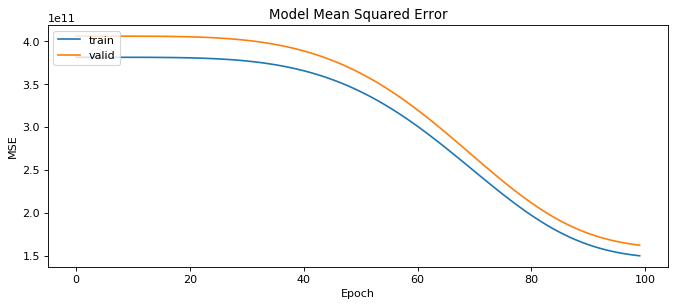

In [195]:
"""plot epoch vs training set mse & epoch vs validation set mse"""

plt.figure(figsize=(10, 4), dpi=80)
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [197]:
print(X_test.shape)
X_test_final.head()

(2449, 18)


,track_name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,month,day
9325,42,35,-0.012279,-1.561038,0.755619,-0.504324,0.74493,-0.298690,1.355040,-0.198030,-1.184338,-0.455732,-0.144622,-1.246752,9,1
15390,22,46,-0.106820,1.306733,-0.854221,0.809192,0.74493,-0.006793,0.299377,-0.198030,-0.735484,1.362352,-1.030065,0.196130,5,26
6054,44,66,-0.477104,2.171498,1.560540,1.230283,0.74493,-0.348703,-0.992490,-0.197974,-1.234211,-0.668536,-0.102366,-0.629720,1,3
10633,43,41,-0.532252,-0.777575,-1.390835,-0.365514,0.74493,-0.456005,-0.331725,-0.198030,-0.820980,-0.016246,-0.637164,-0.024972,3,24
14655,68,28,-1.509172,-0.319323,-0.049301,0.652771,0.74493,-0.813373,-0.856688,-0.198030,-0.498944,-1.371714,0.074951,3.270570,8,3


In [198]:
"""test the random forests model"""

y_vld_pre_rf = rf_model.predict(X_valid_final)
r2_trn_rf = r2_score(y_valid, y_vld_pre_rf)
mse_trn_rf = mean_squared_error(y_valid, y_vld_pre_rf)

y_tst_pre_rf = rf_model.predict(X_test_final)
r2_tst_rf = r2_score(y_test, y_tst_pre_rf)
mse_tst_rf = mean_squared_error(y_test, y_tst_pre_rf)

print('Random Forests Model:')
print('r2 on training set:', r2_trn_rf)
print('mse on training set:', mse_trn_rf)
print('r2 on test set:', r2_tst_rf)
print('mse on test set:', mse_tst_rf)


Random Forests Model:
r2 on training set: 0.9779632339392198
mse on training set: 3040977900.146743
r2 on test set: 0.6413309066225885
mse on test set: 50022949773.93395


In [199]:
"""test the neural networks model"""

y_vld_pre_dnn = dnn_model.predict(X_valid_final)
r2_trn_dnn = r2_score(y_valid, y_vld_pre_dnn)
mse_trn_dnn = mean_squared_error(y_valid, y_vld_pre_dnn)

y_tst_pre_dnn = dnn_model.predict(X_test_final)
r2_tst_dnn = r2_score(y_test, y_tst_pre_dnn)
mse_tst_dnn = mean_squared_error(y_test, y_tst_pre_dnn)

print('Neural Networks Model:')
print('r2 on training set:', r2_trn_dnn)
print('mse on training set:', mse_trn_dnn)
print('r2 on test set:', r2_tst_dnn)
print('mse on test set:', mse_tst_dnn)

Neural Networks Model:
r2 on training set: -0.175077909871711
mse on training set: 162155642303.16937
r2 on test set: -0.21075155169587467
mse on test set: 168861396695.4357


## Conclusion: 
Random Forests model performs better than dnn model in prediction of streams of
Spotify music.  
R squared of Test set is a value of 0.64 which means that 64%of the variance in the
outcome variable is explained by the model.  